In [59]:
import pandas as pd
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

import plotly.graph_objs as go
from plotly.subplots import make_subplots

In [60]:
#Contans
pi = np.pi
kb = 8.617333262145e-5  # Boltzmann constant in eV/K
T = 600 + 273.15        # Temperature in Kelvin

In [61]:
# Helper functions
def D_Coeff(D_0, E_m, T):
    return D_0 * np.exp(-E_m / (kb * T))

def log_factor(r_0, r_L, eps=1e-10):
    logt = np.log(8 * r_L / r_0)
    r = r_0 * logt
    return 1 / r 

def compute_j_L_v(C_Ce_v, C_O_v, D_Ce_v, D_O_v, r_0, r_L, eps=1e-10):
    log_fact = log_factor(r_0, r_L)
    num = D_Ce_v * C_Ce_v * D_O_v * C_O_v
    den = 2 * D_Ce_v * C_Ce_v + D_O_v * C_O_v
    return log_fact * num / den 

def compute_j_L_i(C_Ce_i, C_O_i, D_Ce_i, D_O_i, r_0, r_L, eps=1e-10):
    log_fact = log_factor(r_0, r_L)
    num = D_Ce_i * C_Ce_i * D_O_i * C_O_i
    den = 2 * D_Ce_i * C_Ce_i + D_O_i * C_O_i
    return log_fact * num / den 

def compute_j_ii(C_Ce_i, C_O_i, D_Ce_i, D_O_i, eps=1e-10):
    num = D_Ce_i * (C_Ce_i**2) * D_O_i * (C_O_i**2)
    den = 2 * D_Ce_i * (C_Ce_i**2) + D_O_i * (C_O_i**2)
    return num / den 



In [62]:
# ODE system
def ODE_system(t, y, params):
    C_Ce_v, C_O_v, C_Ce_i, C_O_i, N_L, R_L = y

    G_VCe = params['G_Ce_v']
    G_VO  = params['G_O_v']
    G_CeI = params['G_Ce_i']
    G_OI  = params['G_O_i']
    a     = params['a']
    Omega_0 = (a**3) / 12
    D_Ce_i = params['D_Ce_i']
    D_O_i  = params['D_O_i']
    D_Ce_v = params['D_Ce_v']
    D_O_v  = params['D_O_v']
    r0     = params['r0']
    b = a / np.sqrt(3)

    j_L_v = compute_j_L_v(C_Ce_v, C_O_v, D_Ce_v, D_O_v, r0, R_L)
    j_L_i = compute_j_L_i(C_Ce_i, C_O_i, D_Ce_i, D_O_i, r0, R_L)
    j_ii  = compute_j_ii(C_Ce_i, C_O_i, D_Ce_i, D_O_i)

    k_ce = (Omega_0 / a**2) * (48 * D_Ce_i + 48 * D_Ce_i)
    k_o  = (Omega_0 / a**2) * (36 * D_O_i + 24 * D_O_i)

    beta = 84 * Omega_0 / a**2
    st   = 2 * pi * R_L * N_L

    if j_L_i - j_L_v <= 0:
        j_L_i = j_L_v = 0

    dc = np.zeros(6)
    
    dc[5] = 3 * Omega_0 * 2 * pi * r0 / b * (j_L_i - j_L_v) - R_L / (2 * N_L) * beta * j_ii
    
    if dc[5] < 0 and R_L < 2*r0:
        dc[5] = 0

    dc[0] = G_VCe - k_ce * C_Ce_v * C_Ce_i - j_L_v * pi * r0 * st
    dc[1] = G_VO  - k_o  * C_O_v  * C_O_i  - 2 * j_L_v * pi * r0 * st
    dc[2] = G_CeI - k_ce * C_Ce_i * C_Ce_v - j_L_i * pi * r0 * st - beta * j_ii
    dc[3] = G_OI  - k_o  * C_O_i  * C_O_v  - 2 * j_L_i * pi * r0 * st - 2 * beta * j_ii
    dc[4] = beta * j_ii

    return dc


In [63]:
# Static plotting
def plot_results(results, G_0):
    plt.figure(figsize=(6,5))
    plt.loglog(results['time'], results['C_Ce_v'], label='C_Ce_v')
    plt.loglog(results['time'], results['C_Ce_i'], label='C_Ce_i')
    plt.xlabel('Time [s]'); plt.ylabel('Concentration [cm^-3]')
    plt.legend(); plt.title('Vacancy Concentrations')
    plt.show()

    plt.figure(figsize=(6,5))
    plt.loglog(results['time'], results['C_O_v'], label='C_O_v')
    plt.loglog(results['time'], results['C_O_i'], label='C_O_i')
    plt.xlabel('Time [s]'); plt.ylabel('Concentration [cm^-3]')
    plt.legend(); plt.title('Interstitial Concentrations')
    plt.show()

    plt.figure(figsize=(6,5))
    plt.plot(results['time']*G_0, results['N_L']*1e-16, label='N_L')
    plt.xlabel('Dose (dpa)'); plt.ylabel('Loop Density ×10$^{16}$ [cm^-3]')
    plt.legend(); plt.title('Dislocation Loop Density')
    plt.show()

    plt.figure(figsize=(6,5))
    plt.plot(results['time']*G_0, results['R_L']*1e7, label='R_L')
    plt.xlabel('Dose (dpa)'); plt.ylabel('Loop Radius [nm]')
    plt.legend(); plt.title('Dislocation Loop Radius')
    plt.show()

In [64]:

def interactive_plots(results, G_0):
    time = results['time']
    dose = time * G_0

    # Ce Concentrations
    fig1 = go.Figure()
    fig1.add_trace(go.Scatter(x=time, y=results['C_Ce_v'],
                              mode='lines', name='C_Ce_v'))
    fig1.add_trace(go.Scatter(x=time, y=results['C_Ce_i'],
                              mode='lines', name='C_Ce_i'))
    fig1.update_layout(title="Vacancy Concentrations",
                       xaxis=dict(title="Time [s]", type="log",  exponentformat='power'),
                       yaxis=dict(title="Concentration [cm<sup>-3</sup>]", type="log", exponentformat='power'),
                       width=600, height=500)
    fig1.show()

    # O Concentrations
    fig2 = go.Figure()
    fig2.add_trace(go.Scatter(x=time, y=results['C_O_v'],
                              mode='lines', name='C_O_v'))
    fig2.add_trace(go.Scatter(x=time, y=results['C_O_i'],
                              mode='lines', name='C_O_i'))
    fig2.update_layout(title="Interstitial Concentrations",
                       xaxis=dict(title="Time [s]", type="log", exponentformat='power'),
                       yaxis=dict(title="Concentration [cm<sup>-3</sup>]", type="log", exponentformat='power'),
                       width=600, height=500)
    fig2.show()

    # Loop density
    fig3 = go.Figure()
    fig3.add_trace(go.Scatter(x=dose, y=results['N_L']*1e-16,
                              mode='lines', name='N_L', line_color='#fc0100'))
    fig3.update_layout(title="Dislocation Loop Density",
                       xaxis=dict(title="Dose [dpa]"),
                       yaxis=dict(title="Loop Density [ 10<sup>16</sup> cm<sup>-3</sup>] "),
                       width=600, height=500)
    fig3.update_xaxes(title_font_size=22, tickfont_size=18)
    fig3.update_yaxes(title_font_size=22, tickfont_size=18)
    fig3.show()

    # Loop radius
    fig4 = go.Figure()
    fig4.add_trace(go.Scatter(x=dose, y=results['R_L']*1e7/2,
                              mode='lines', name='R_L',line_color='#fc0100'))
    fig4.update_layout(title="Dislocation Loop Radius",
                       xaxis=dict(title="Dose [dpa]"),
                       yaxis=dict(title="Loop Radius [nm]"),
                       width=600, height=500)
    fig4.update_xaxes(title_font_size=22, tickfont_size=18)
    fig4.update_yaxes(title_font_size=22, tickfont_size=18) 
    fig4.show()
    return (fig1,fig2,fig3,fig4)


<h3>Solving equations</h3>

In [65]:
#Parameters
a = 541e-10   # cm
N = 12 
Omega_0 = (a**3) / N
b = a / np.sqrt(3)

D_0_Ce_v, D_0_Ce_i, D_0_O_v, D_0_O_i = 0.65, 0.01, 0.02, 0.01
#E_m_Ce_v, E_m_Ce_i, E_m_O_v, E_m_O_i = 5.3, 2.6, 0.836, 1.60
E_m_Ce_v, E_m_Ce_i, E_m_O_v, E_m_O_i = 5.3, 2.6, 0.836, 1.18

# Dose rate dpa/s
#G_0 = 0.87e-6 #LF
G_0 = 2.6e-6   #HF

ratio = 2
G_tot = G_0 / Omega_0
G_Ce = G_tot * (ratio / (1 + ratio))
G_O  = G_Ce   * (1 - ratio / (1 + ratio))

params = {
    'G_Ce_v': G_Ce, 'G_O_v': G_O,
    'G_Ce_i': G_Ce, 'G_O_i': G_O,
    'a': a, 
    'D_Ce_i': D_Coeff(D_0_Ce_i, E_m_Ce_i, T),
    'D_Ce_v': D_Coeff(D_0_Ce_v, E_m_Ce_v, T),
    'D_O_i':  D_Coeff(D_0_O_i,  E_m_O_i, T),
    'D_O_v':  D_Coeff(D_0_O_v,  E_m_O_v, T),
    'r0': 4*a,
}

print(f"D_Ce_i = {params['D_Ce_i']:.3e} cm^2/s")
print(f"D_Ce_v = {params['D_Ce_v']:.3e} cm^2/s")
print(f"D_O_i  = {params['D_O_i']:.3e} cm^2/s")
print(f"D_O_v  = {params['D_O_v']:.3e} cm^2/s")
print(f"G_Ce   = {params['G_Ce_v']:.3e} dpa/(s*cm^3)")
print(G_O)


D_Ce_i = 9.839e-18 cm^2/s
D_Ce_v = 1.666e-31 cm^2/s
D_O_i  = 1.546e-09 cm^2/s
D_O_v  = 2.990e-07 cm^2/s
G_Ce   = 1.314e+17 dpa/(s*cm^3)
4.378751357073462e+16


In [66]:
# Initial conditions
t0 = 0.0001149
y0 = [G_Ce*t0, G_O*t0, G_Ce*t0, G_O*t0, G_O*t0*1e-6, np.sqrt(N*Omega_0/(pi*b))]

# Total time from total dose
dmg = 1.2   # dpa
t_end = dmg / G_0
t_span = (t0, t_end)
t_eval = np.linspace(t0, t_end, 1000)

solution = solve_ivp(ODE_system, method='BDF', t_span=t_span, y0=y0,
                     args=(params,), t_eval=t_eval)


In [67]:
# Collect results and plot
results = pd.DataFrame(solution.y.T,
                       columns=['C_Ce_v','C_O_v','C_Ce_i','C_O_i','N_L','R_L'])
results['time'] = solution.t


In [68]:
#static plots
#plot_results(results, G_0)

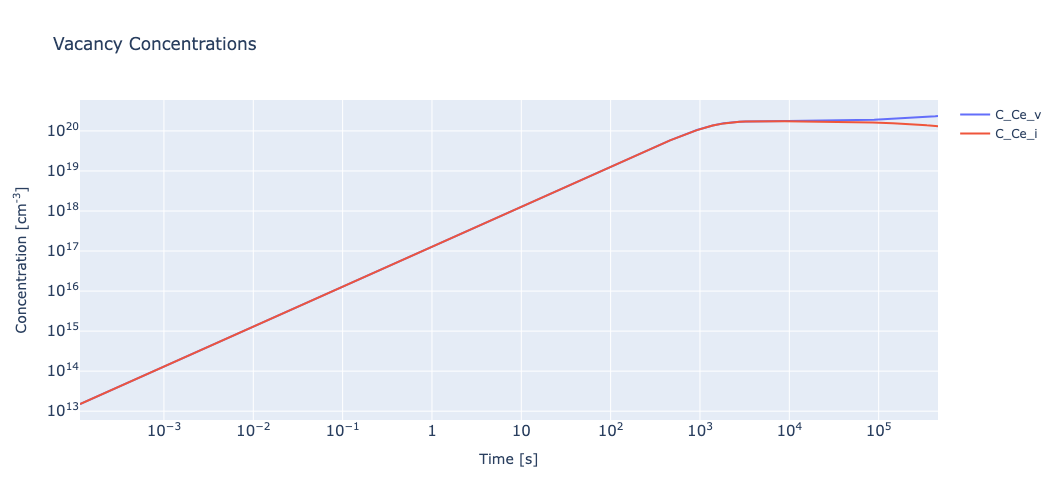

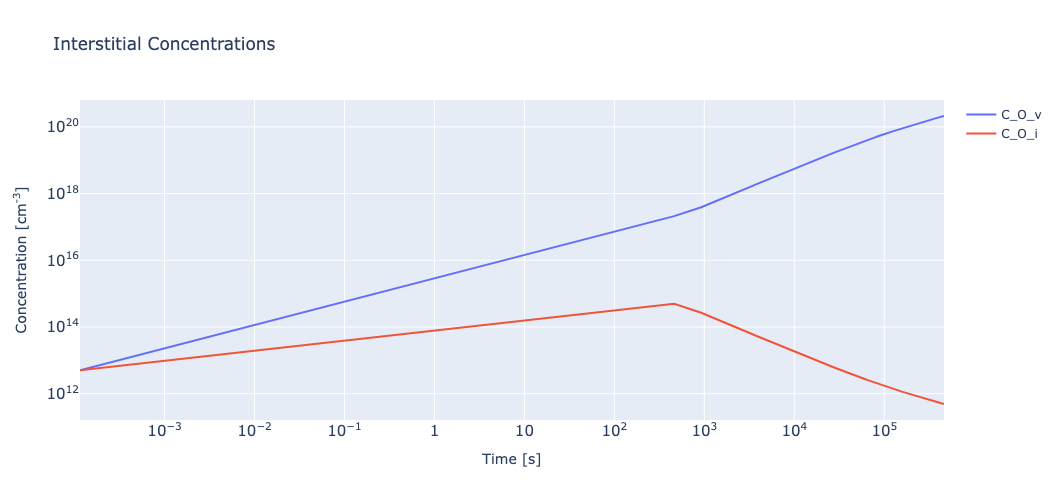

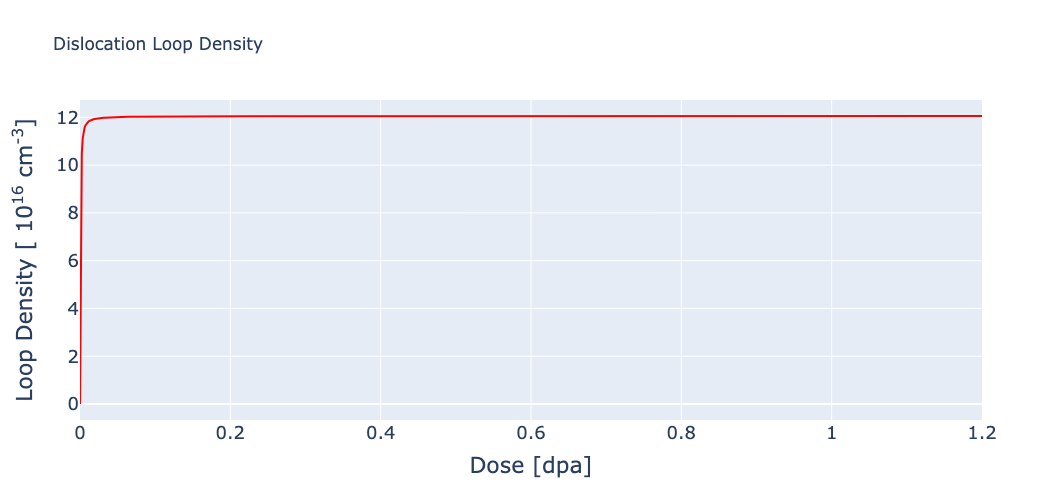

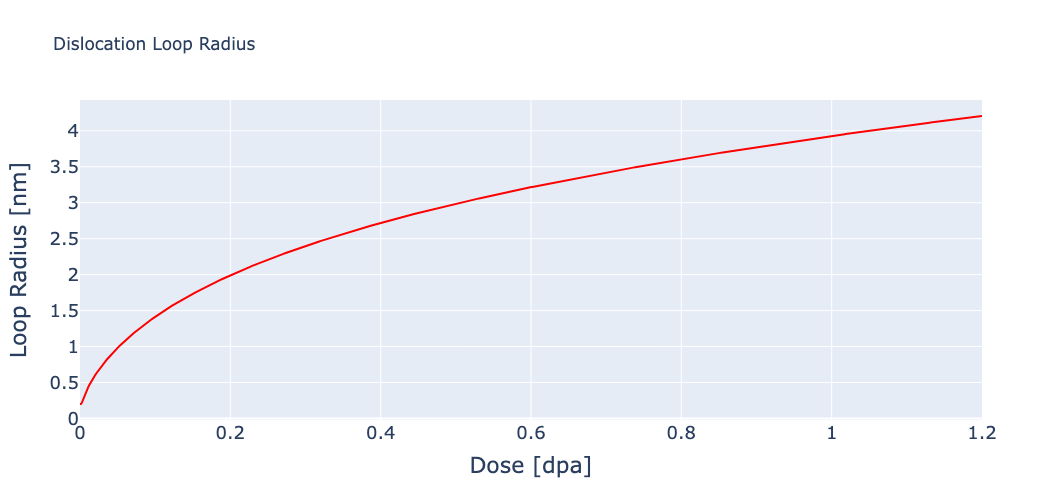

In [69]:
figs = interactive_plots(results, G_0)

names = {0:"Ce-concentrations",
        1:"O-concentrations",
        2:"Loop-Density",
        3:"Loop-radius"}

for i,fig in enumerate(figs):
    file_name = f"../../images/plot-{names[i]}-HF.svg"
    fig.write_image(file_name)



In [70]:
# Dose rate dpa/s
G_0 = 0.87e-6 #LF
#G_0 = 2.6e-6   #HF

ratio = 2
G_tot = G_0 / Omega_0
G_Ce = G_tot * (ratio / (1 + ratio))
G_O  = G_Ce   * (1 - ratio / (1 + ratio))

params = {
    'G_Ce_v': G_Ce, 'G_O_v': G_O,
    'G_Ce_i': G_Ce, 'G_O_i': G_O,
    'a': a, 
    'D_Ce_i': D_Coeff(D_0_Ce_i, E_m_Ce_i, T),
    'D_Ce_v': D_Coeff(D_0_Ce_v, E_m_Ce_v, T),
    'D_O_i':  D_Coeff(D_0_O_i,  E_m_O_i, T),
    'D_O_v':  D_Coeff(D_0_O_v,  E_m_O_v, T),
    'r0': 4*a,
}

print(f"D_Ce_i = {params['D_Ce_i']:.3e} cm^2/s")
print(f"D_Ce_v = {params['D_Ce_v']:.3e} cm^2/s")
print(f"D_O_i  = {params['D_O_i']:.3e} cm^2/s")
print(f"D_O_v  = {params['D_O_v']:.3e} cm^2/s")
print(f"G_Ce   = {params['G_Ce_v']:.3e} dpa/(s*cm^3)")

D_Ce_i = 9.839e-18 cm^2/s
D_Ce_v = 1.666e-31 cm^2/s
D_O_i  = 1.546e-09 cm^2/s
D_O_v  = 2.990e-07 cm^2/s
G_Ce   = 4.396e+16 dpa/(s*cm^3)


In [71]:
# Initial conditions
t0 = 0.0001149
y0 = [G_Ce*t0, G_O*t0, G_Ce*t0, G_O*t0, G_O*t0*1e-6, np.sqrt(N*Omega_0/(pi*b))]

# Total time from total dose
dmg = 1.2   # dpa
t_end = dmg / G_0
t_span = (t0, t_end)
t_eval = np.linspace(t0, t_end, 1000)

solution = solve_ivp(ODE_system, method='BDF', t_span=t_span, y0=y0,
                     args=(params,), t_eval=t_eval)


In [72]:
# Collect results and plot
results = pd.DataFrame(solution.y.T,
                       columns=['C_Ce_v','C_O_v','C_Ce_i','C_O_i','N_L','R_L'])
results['time'] = solution.t

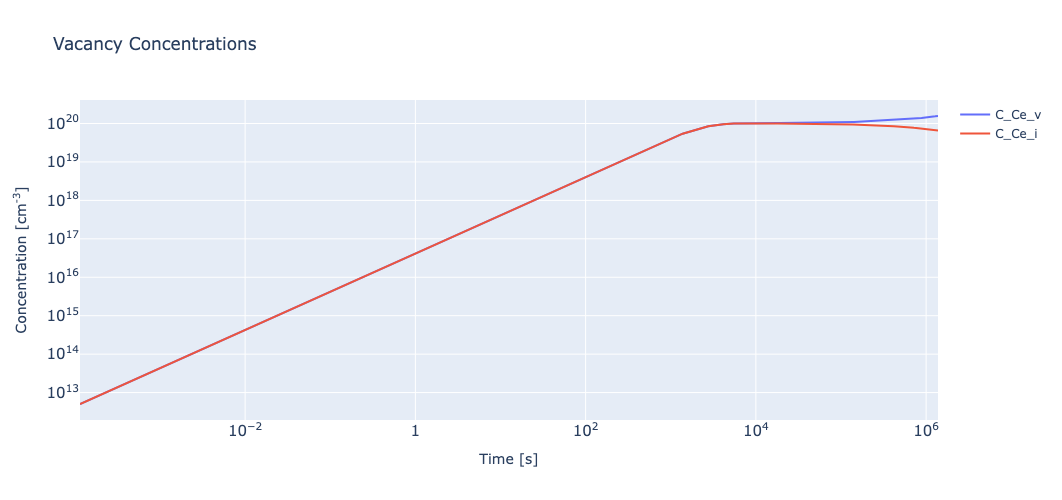

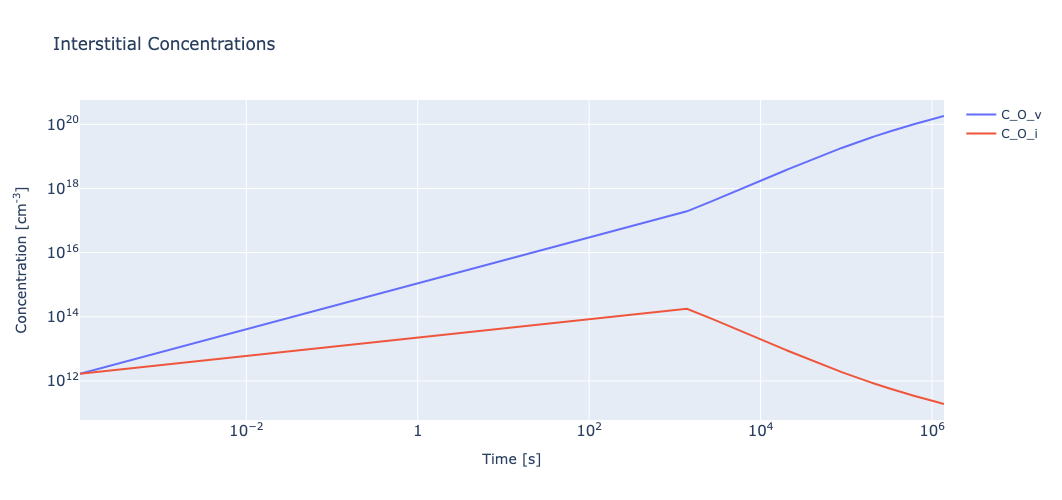

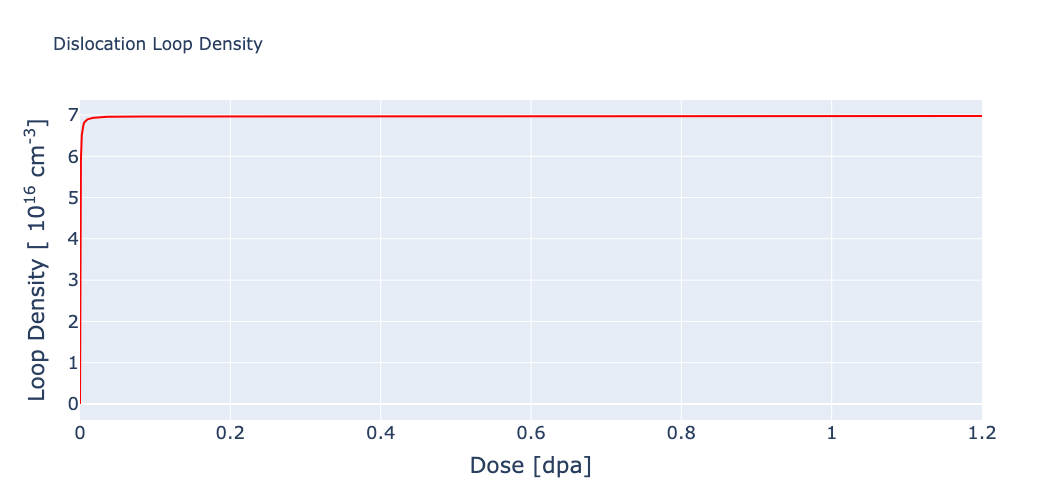

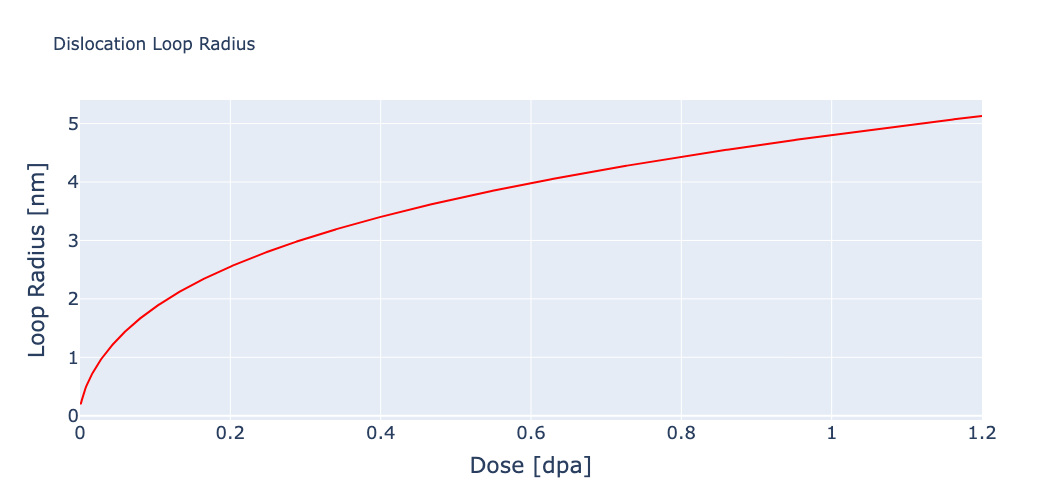

In [73]:
figs = interactive_plots(results, G_0)

names = {0:"Ce-concentrations",
        1:"O-concentrations",
        2:"Loop-Density",
        3:"Loop-radius"}

for i,fig in enumerate(figs):
    file_name = f"../../images/plot-{names[i]}-LF.svg"
    fig.write_image(file_name)

In [74]:
T = 600 + 273.15

In [75]:
E_m_Ce_v, E_m_Ce_i, E_m_O_v, E_m_O_i = 5.3, 2.6, 0.836, 1.186

# Dose rate dpa/s
#G_0 = 0.87e-6 #LF
G_0 = 2.6e-6   #HF

ratio = 2
G_tot = G_0 / Omega_0
G_Ce = G_tot * (ratio / (1 + ratio))
G_O  = G_Ce   * (1 - ratio / (1 + ratio))

params = {
    'G_Ce_v': G_Ce, 'G_O_v': G_O,
    'G_Ce_i': G_Ce, 'G_O_i': G_O,
    'a': a, 
    'D_Ce_i': D_Coeff(D_0_Ce_i, E_m_Ce_i, T),
    'D_Ce_v': D_Coeff(D_0_Ce_v, E_m_Ce_v, T),
    'D_O_i':  D_Coeff(D_0_O_i,  E_m_O_i, T),
    'D_O_v':  D_Coeff(D_0_O_v,  E_m_O_v, T),
    'r0': 4*a,
}

print(f"D_Ce_i = {params['D_Ce_i']:.3e} cm^2/s")
print(f"D_Ce_v = {params['D_Ce_v']:.3e} cm^2/s")
print(f"D_O_i  = {params['D_O_i']:.3e} cm^2/s")
print(f"D_O_v  = {params['D_O_v']:.3e} cm^2/s")
print(f"G_Ce   = {params['G_Ce_v']:.3e} dpa/(s*cm^3)")

D_Ce_i = 9.839e-18 cm^2/s
D_Ce_v = 1.666e-31 cm^2/s
D_O_i  = 1.427e-09 cm^2/s
D_O_v  = 2.990e-07 cm^2/s
G_Ce   = 1.314e+17 dpa/(s*cm^3)


In [76]:
# Initial conditions
t0 = 0.0001149
y0 = [G_Ce*t0, G_O*t0, G_Ce*t0, G_O*t0, G_O*t0*1e-6, np.sqrt(N*Omega_0/(pi*b))]

# Total time from total dose
dmg = 1.2   # dpa
t_end = dmg / G_0
t_span = (t0, t_end)
t_eval = np.linspace(t0, t_end, 1000)

solution = solve_ivp(ODE_system, method='BDF', t_span=t_span, y0=y0,
                     args=(params,), t_eval=t_eval)


In [77]:
# Collect results and plot
results = pd.DataFrame(solution.y.T,
                       columns=['C_Ce_v','C_O_v','C_Ce_i','C_O_i','N_L','R_L'])
results['time'] = solution.t

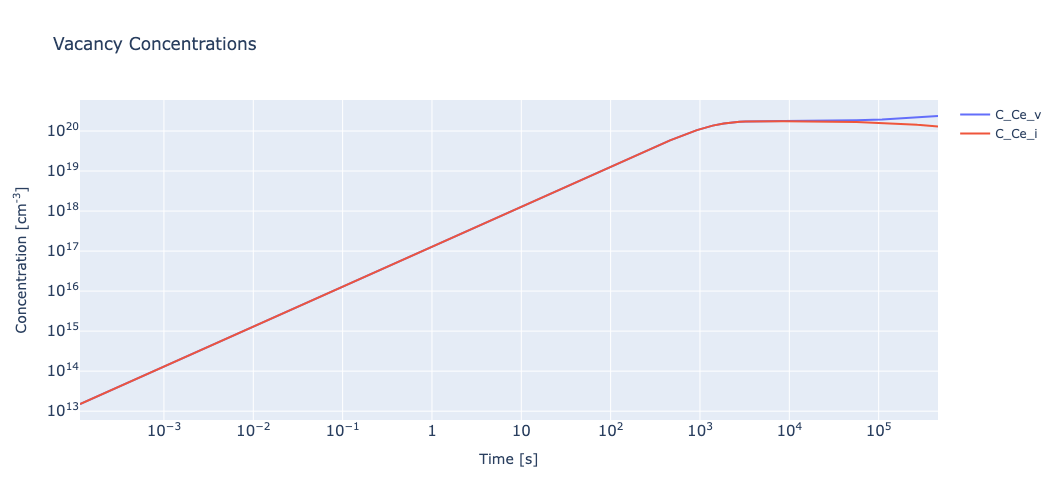

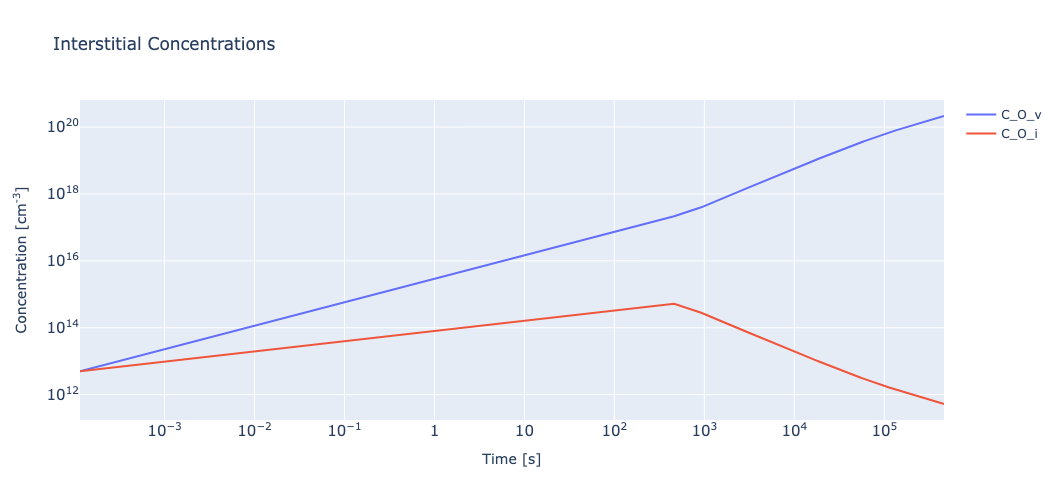

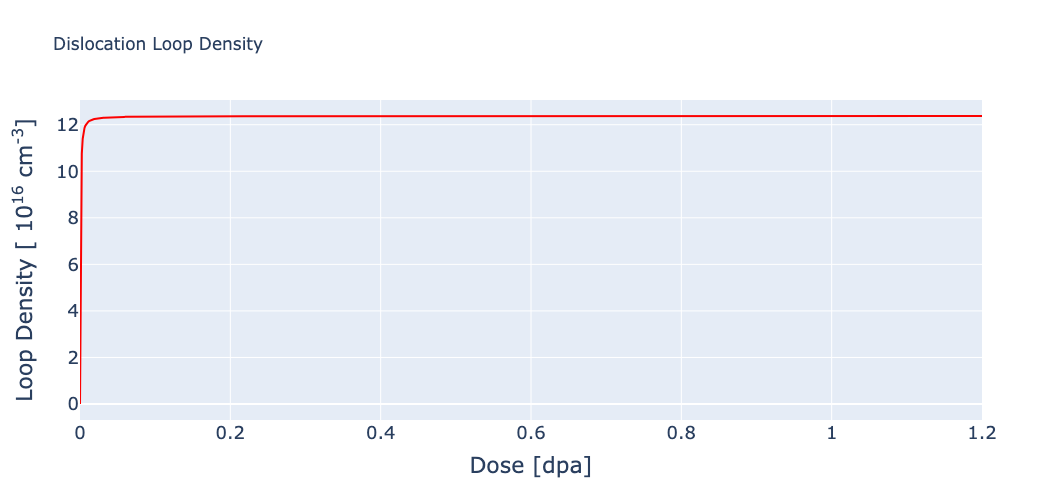

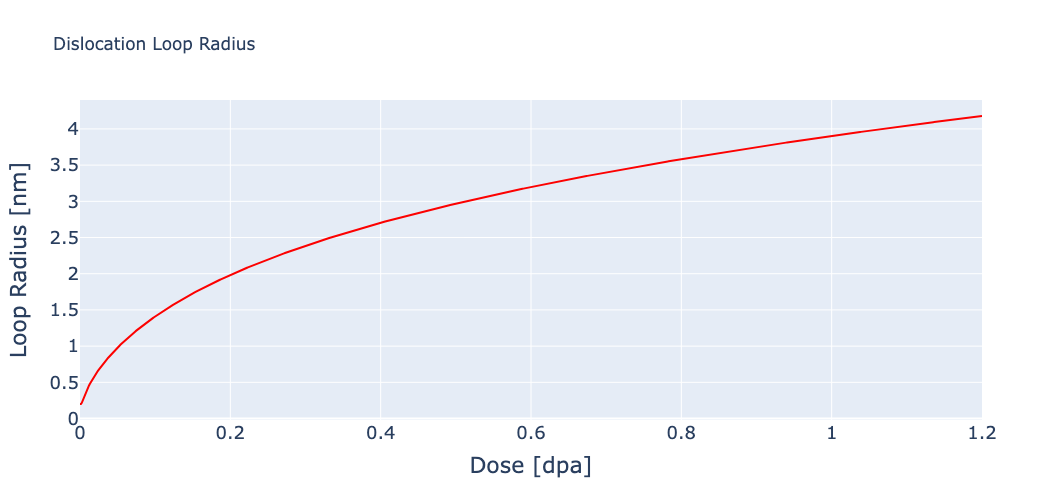

In [78]:
_ = interactive_plots(results, G_0)